### Exploration of processed bulk ATAC and RNA data

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import anndata as ad
import scanpy as sc
import os
import re
from bs4 import BeautifulSoup

In [3]:
# set filepath parameters

datafolder = '/projectnb/paxlab/EnhancerDiscovery/data'
atac_datafolder = f'{datafolder}/Bulk-ATAC-Heart-Lung-Liver_Human_FBs/NF_out'
rna_datafolder = f'{datafolder}/Bulk-Ribo-Depleted-RNAseq-Heart-Lung-Liver_Human_FBs/hFB_riboDepletedBulkRnaSeq/NF_out'

#### RNA QC

In [4]:
rna_qc = f'{rna_datafolder}/multiqc/star_salmon/multiqc_report_data'

<Axes: xlabel='mean', ylabel='Count'>

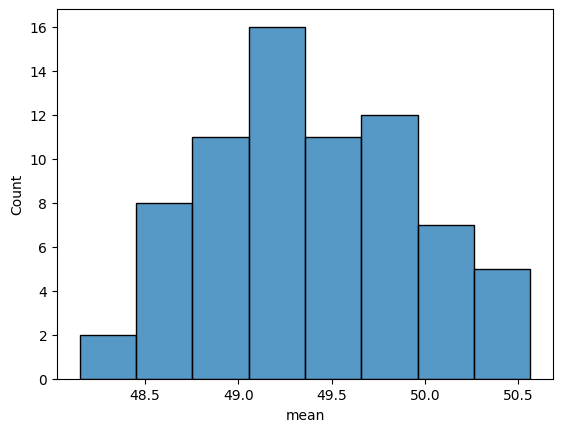

In [5]:
# gc content
gc_content = pd.read_table(f'{rna_qc}/mqc_fastqc_per_sequence_gc_content_plot_Percentages.txt', index_col=0)
gc_content['mean'] = [np.mean([float(col) * row[col] for col in gc_content.columns]) for _, row in gc_content.iterrows()]
sns.histplot(gc_content, x='mean')

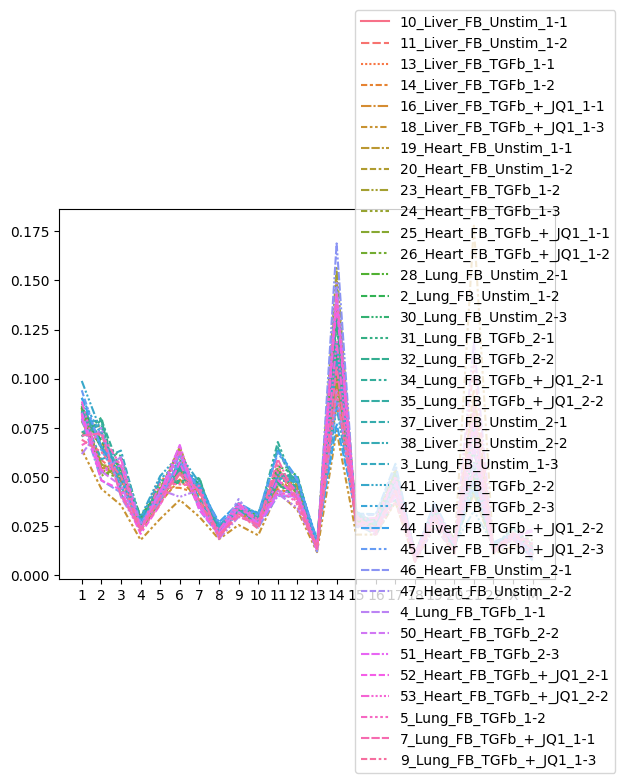

In [6]:
# mapped read coverage
mapped_reads = pd.read_table(f'{rna_qc}/mqc_samtools-idxstats-mapped-reads-plot_Normalised_Counts.txt', index_col=0)
mapped_reads.rename(columns = lambda c: c[3:], inplace=True)
sns.lineplot(mapped_reads.T.drop(index=['1_KI270713v1_random', '22_KI270733v1_random', 'Un_GL000220v1']))
plt.legend().remove()
plt.gcf().legend().set_loc('outside right')

<Axes: xlabel='pct_mapped', ylabel='Count'>

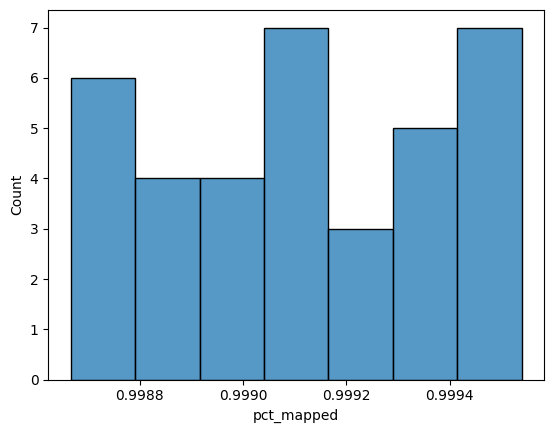

In [7]:
# total pct mapped reads
mapped_reads['pct_mapped'] = [sum(row) for _, row in mapped_reads.iterrows()]
sns.histplot(mapped_reads, x='pct_mapped')

<Axes: xlabel='Total reads', ylabel='Count'>

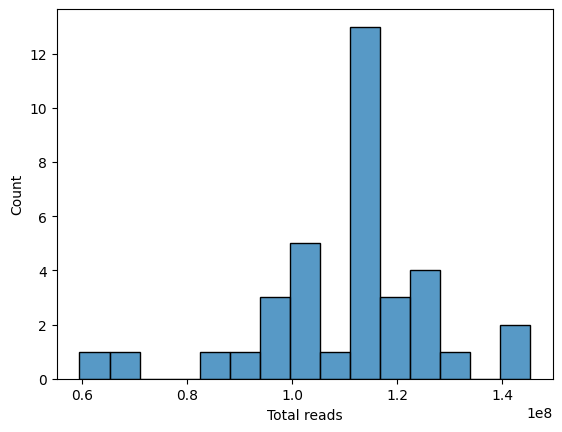

In [8]:
# Number of reads mapped
raw_mapped_reads = pd.read_table(f'{rna_qc}/mqc_samtools-idxstats-mapped-reads-plot_Raw_Counts.txt', index_col=0)
raw_mapped_reads['Total reads'] = raw_mapped_reads.aggregate('sum', axis=1)
sns.histplot(raw_mapped_reads, x = 'Total reads', bins=15)

### ATAC QC

In [9]:
atac_qc = f'{atac_datafolder}/fastqc'

In [10]:
sample_to_stats = {}
for file in os.listdir(atac_qc):
  if not os.path.isfile(f'{atac_qc}/{file}'):
    continue
  sample = file.split('_fastqc.')[0]
  sample_stats = {}
  with open(f'{atac_qc}/{file}', 'r') as qc:
    soup = BeautifulSoup(qc.read(), 'html.parser')
    for li in soup.find(name='ul').children:
      img, desc = li.children
      sample_stats[desc.text] = img.attrs['alt'][1:-1]
  sample_to_stats[sample] = sample_stats
atac_qc_df = pd.DataFrame(sample_to_stats).T

In [11]:
atac_qc_df.head()

,Basic Statistics,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content
TGFB_JQ1_Heart_REP1_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,WARNING
TGFB_Heart_REP2_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,WARNING
TGFB_Lung_REP1_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,PASS
TGFB_JQ1_Liver_REP1_T1_1,PASS,PASS,FAIL,PASS,FAIL,PASS,PASS,PASS,PASS,PASS,WARNING
TGFB_Lung_REP3_T1_1,PASS,PASS,FAIL,PASS,FAIL,PASS,PASS,PASS,PASS,PASS,WARNING


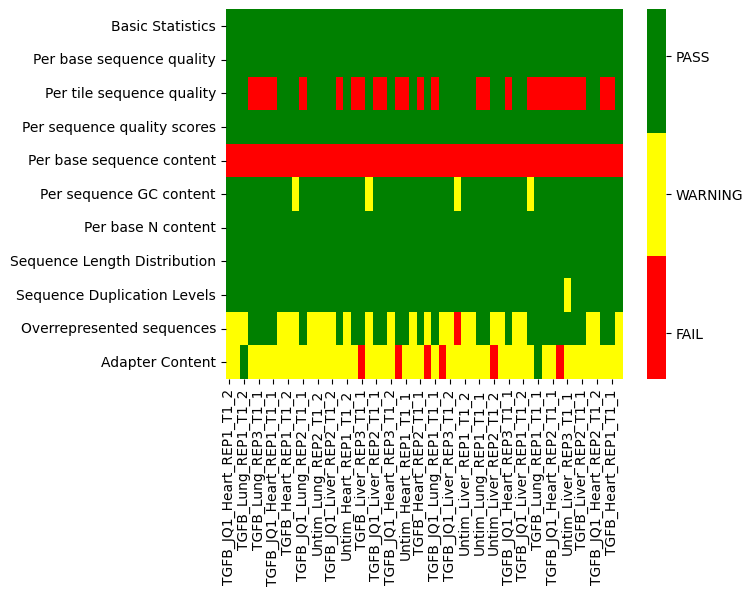

In [12]:
ax = sns.heatmap(atac_qc_df.T.map(lambda el: 2 if el == 'PASS' else 1 if el == 'WARNING' else 0), cmap=['red', 'yellow', 'green'])
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(colorbar.get_ticks(minor=False)[1:9:3], labels = ['FAIL', 'WARNING', 'PASS'])

#### Diving into the samples

In [13]:
# Using muon (https://github.com/scverse/muon) for multiomic data structure
# First load into individual AnnData structures

rna_tpm = f'{rna_datafolder}/star_salmon/salmon.merged.transcript_tpm.tsv'
rna_df = pd.read_table(rna_tpm, index_col=0)
genes = rna_df['gene_id']
rna_df.drop(columns = 'gene_id', inplace=True)

rna_adata = ad.AnnData(rna_df.T)

In [14]:
rna_adata.var['gene'] = genes
rna_adata.obs['organ'] = [re.search(r"Heart|Lung|Liver", sample).group(0) for sample in rna_adata.obs_names]
rna_adata.obs['condition'] = [re.search(r"Unstim|TGFb(_._JQ1)?", sample).group(0).replace('_._', '+') for sample in rna_adata.obs_names]
rna_adata.obs['replicate'] = [re.search(r"[1-2]\.[1-3]", sample).group(0) for sample in rna_adata.obs_names]
rna_adata.obs_names = [f'{row['organ']}_{row['condition']}_REP{row['replicate']}' for _, row in rna_adata.obs.iterrows()]
rna_adata

AnnData object with n_obs × n_vars = 36 × 87398
    obs: 'organ', 'condition', 'replicate'
    var: 'gene'

In [15]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'TGFb+JQ1': '#1f77b4'}
markers = {'Lung': 'o', 'Heart': '^', 'Liver': 's'}

<Axes: xlabel='organ', ylabel='Count'>

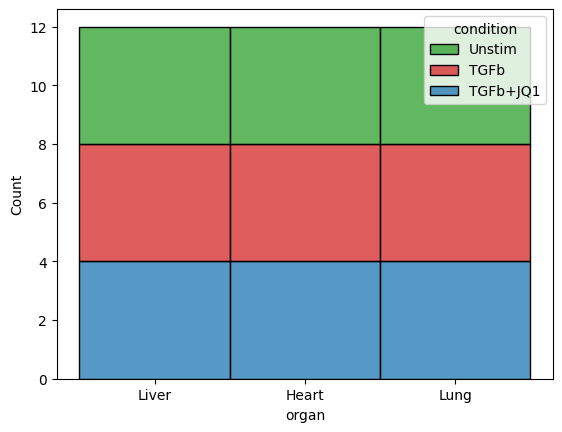

In [16]:
sns.histplot(rna_adata.obs, x='organ', hue='condition', multiple='stack', palette=palette, hue_order=palette.keys())

In [17]:
atac_peaks = f'{atac_datafolder}/bwa/merged_library/macs2/broad_peak/consensus/consensus_peaks.mLb.clN.featureCounts.txt'
atac_df = pd.read_table(atac_peaks, index_col=0, header=1)
atac_vars = atac_df[['Chr', 'Start', 'End', 'Strand', 'Length']]
atac_df.drop(columns = ['Chr', 'Start', 'End', 'Strand', 'Length'], inplace=True)

atac_adata = ad.AnnData(atac_df.T)

In [18]:
atac_adata.var = atac_vars
atac_adata.obs['organ'] = [re.search(r"Heart|Lung|Liver", sample).group(0) for sample in atac_adata.obs_names]
atac_adata.obs['condition'] = [re.search(r"Untim|TGFB(_JQ1)?", sample).group(0).replace('TGFB_', 'TGFB+').replace('TGFB', 'TGFb').replace('Untim', 'Unstim') for sample in atac_adata.obs_names]
atac_adata.obs['replicate'] = [re.search(r"REP[1-3]", sample).group(0) for sample in atac_adata.obs_names]
atac_adata.obs_names = [f'{row['organ']}_{row['condition']}_{row['replicate']}' for _, row in atac_adata.obs.iterrows()]
atac_adata

AnnData object with n_obs × n_vars = 26 × 164814
    obs: 'organ', 'condition', 'replicate'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

<Axes: xlabel='organ', ylabel='Count'>

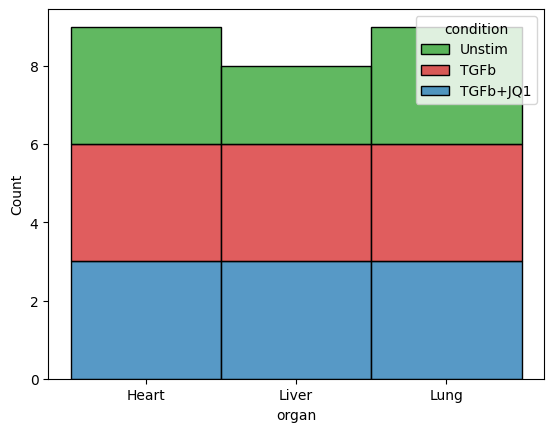

In [19]:
sns.histplot(atac_adata.obs, x='organ', hue='condition', multiple='stack', palette=palette, hue_order=palette.keys())

#### Principal Component Analysis

Are differences in gene expression and peaks primarily due to organ or condition?

In [20]:
def plot_organ_pca(adata: ad.AnnData, **kwargs) -> plt.Figure:
  fig, axs = plt.subplots(2, 2)
  for i, (organ, marker) in enumerate(markers.items()):
    sub = adata[adata.obs['organ'] == organ].copy()
    sc.pl.embedding(sub, 'pca', color='condition', palette=palette, s=50, title=organ, marker=marker, ax=axs[i % 2][int(i / 2)], show=False, use_raw=False, legend_loc='best' if i == 2 else None, **kwargs)
    sc.pl.embedding(sub, 'pca', color='condition', palette=palette, s=50, title='All', marker=marker, ax=axs[1][1], legend_loc=None, use_raw=False, show=False, **kwargs)

  plt.tight_layout()
  return fig

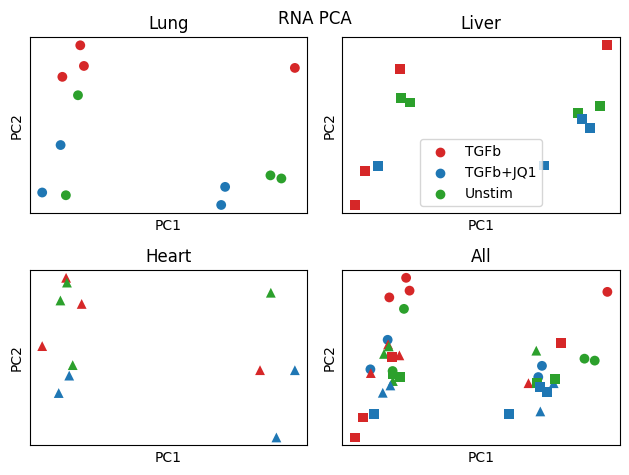

In [21]:
sc.pp.pca(rna_adata)
fig = plot_organ_pca(rna_adata)
fig.suptitle("RNA PCA")
plt.show()

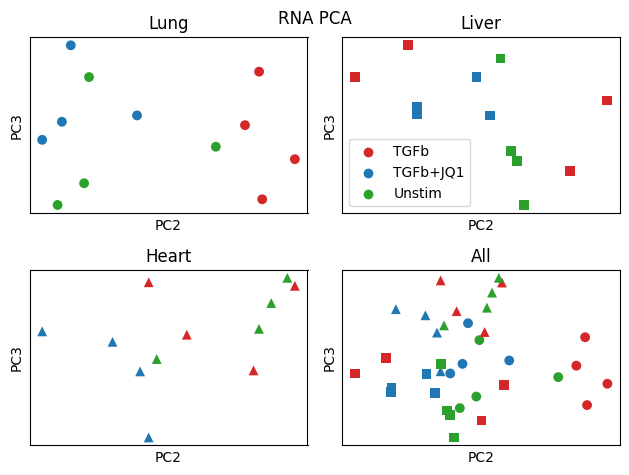

In [22]:
fig = plot_organ_pca(rna_adata, components='2,3')
fig.suptitle("RNA PCA")
plt.show()

In [23]:
### Regress out PC1
# PC1 seems to show stratification unrelated to condition/organ
rna_adata.obs['PC1'] = rna_adata.obsm['X_pca'][:, 0]
rna_adata_reg = sc.pp.regress_out(rna_adata, 'PC1', copy=True)
rna_adata.layers['post-regression'] = rna_adata_reg.X

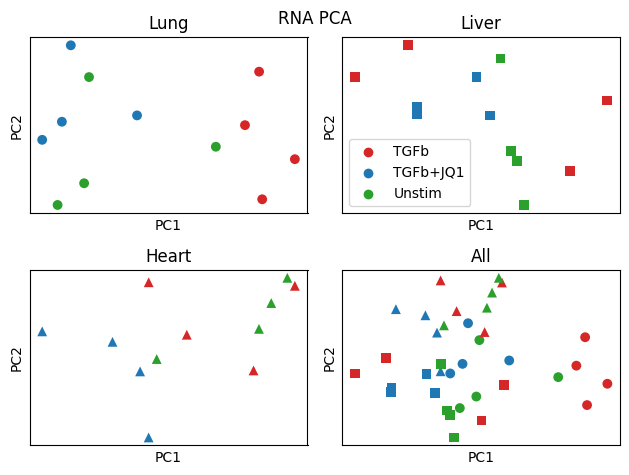

In [24]:
sc.pp.pca(rna_adata, layer='post-regression')
fig = plot_organ_pca(rna_adata, layer='post-regression')
fig.suptitle("RNA PCA")
plt.show()

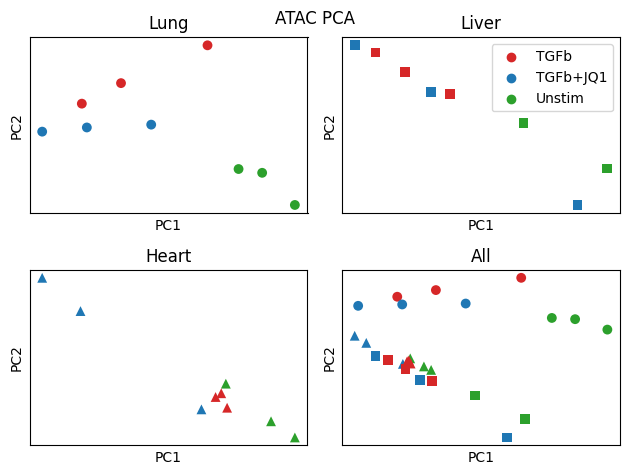

In [25]:
sc.pp.pca(atac_adata)
fig = plot_organ_pca(atac_adata)
fig.suptitle("ATAC PCA")
plt.show()

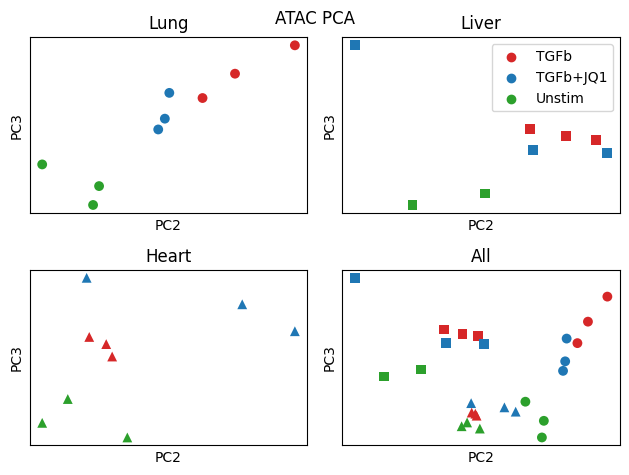

In [26]:
sc.pp.pca(atac_adata)
fig = plot_organ_pca(atac_adata, components='2,3')
fig.suptitle("ATAC PCA")
plt.show()

In [27]:
### Regress out PC1
# PC1 seems to show stratification unrelated to condition/organ
atac_adata.obs['PC1'] = atac_adata.obsm['X_pca'][:, 0]
atac_adata_reg = sc.pp.regress_out(atac_adata, 'PC1', copy=True)
atac_adata.layers['post-regression'] = atac_adata_reg.X

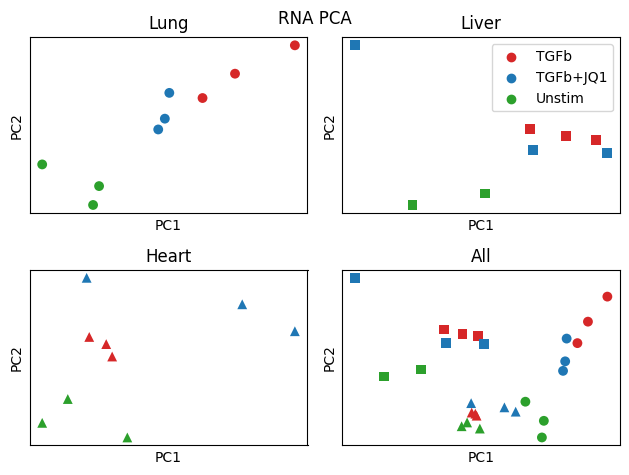

In [28]:
sc.pp.pca(atac_adata, layer='post-regression')
fig = plot_organ_pca(atac_adata, layer='post-regression')
fig.suptitle("RNA PCA")
plt.show()

#### Prior knowledge validation

Based on prior heart studies in mice, we expect to see:
- Periostin (Postn) expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 expression to increase with TAC and decrease with TAC+JQ1
- MEOX1 peaks to increase with TAC and decrease with TAC+JQ1
  - This data is human so peaks will likely not be 1:1 with mice data

In [29]:
# boxplot of expression over organ/condition
def plot_expression(adata: ad.AnnData, gene: str, layer: str = None, **kwargs) -> plt.Axes:
  gene_rna_adata = adata[:, adata.var['gene'] == gene]
  ax = sns.boxplot(gene_rna_adata.obs, x = 'organ', y = gene_rna_adata.to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{gene} expression {layer if layer is not None else ""}')
  return ax

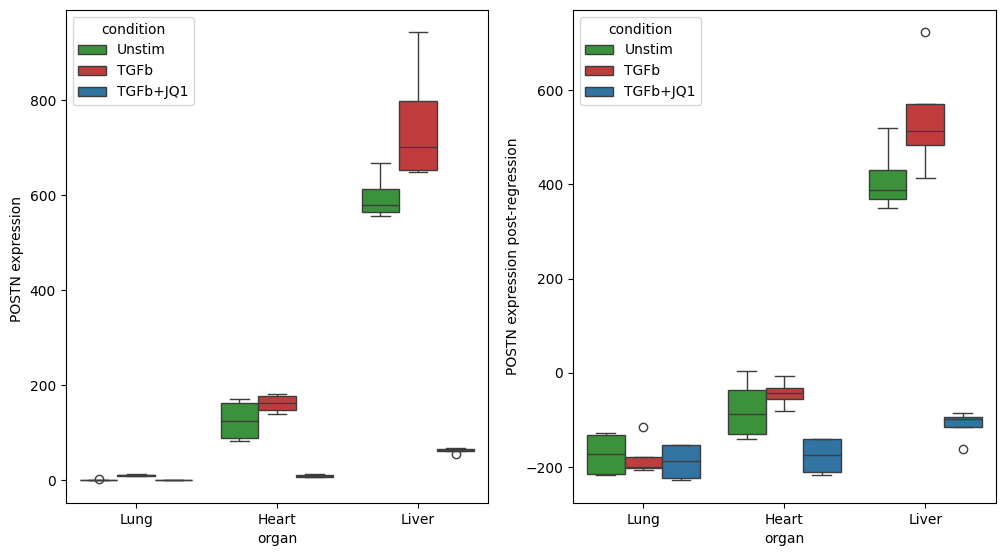

In [30]:
# Periostin expression pre- and post-regression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'POSTN', ax=ax1)
plot_expression(rna_adata, gene = 'POSTN', layer = 'post-regression', ax=ax2)
plt.show()

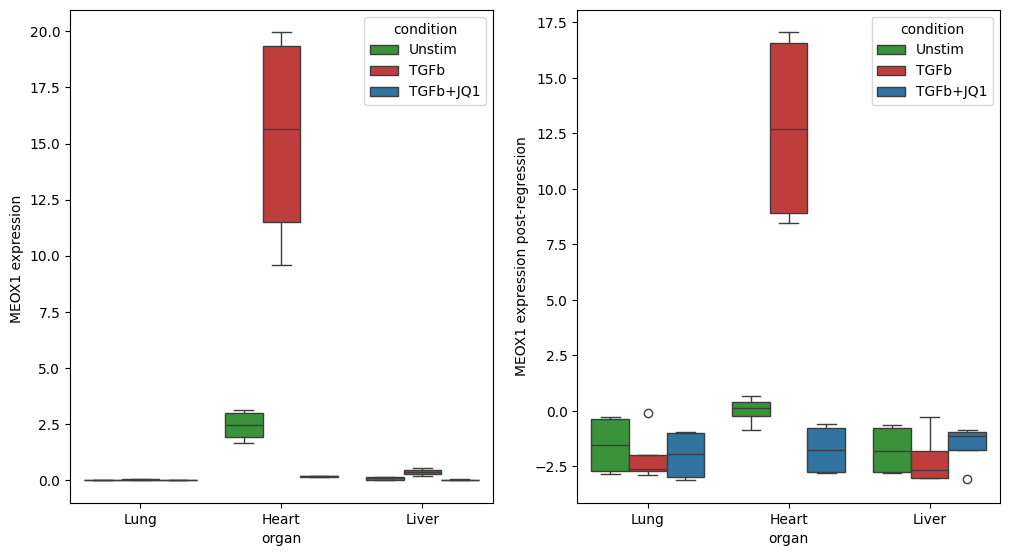

In [31]:
# MEOX1 expression
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_expression(rna_adata, gene = 'MEOX1', ax=ax1)
plot_expression(rna_adata, gene = 'MEOX1', layer = 'post-regression', ax=ax2)
plt.show()

In [32]:
# heatmap of atac peaks over location range. also boxes the (approximate) gene open reading frame
def plot_peak_range(adata: ad.AnnData, chr: int, orf: tuple[float, float], layer: str = None, range = 1.5 * 10 ** 5, **kwargs) -> plt.Axes:
  orf = (orf[0] * 10 ** 6, orf[1] * 10 ** 6)
  peak_adata = adata[:, (adata.var['Chr'] == f'chr{chr}') & (adata.var['Start'] >= orf[0] - range) & (adata.var['Start'] <= orf[1] + range)]
  peak_heatmap_df = pd.DataFrame({
    f"{organ}-{condition}": {
      peak: np.mean(peak_adata[rows.index, peak]._get_X(layer = layer)) for peak in peak_adata.var_names
    }
    for (organ, condition), rows in peak_adata.obs.groupby(['organ', 'condition'])
  }, dtype = 'float64')
  peak_heatmap_df = peak_heatmap_df[[f"{organ}-{condition}" for organ in markers.keys() for condition in palette.keys()]]
  ax = sns.heatmap(peak_heatmap_df, cmap = 'viridis', **kwargs)
  ax.set_ylabel("Peak")
  ax.set_xlabel("Organ-Condition")
  coding_index = peak_adata[:, (peak_adata.var['Start'] >= orf[0]) & (peak_adata.var['Start'] <= orf[1])].var_names
  ax.add_patch(plt.Rectangle((0, peak_heatmap_df.index.get_loc(coding_index[0])), len(peak_heatmap_df.columns), len(coding_index), fill=False, edgecolor='crimson', lw=2, clip_on=False))
  return ax

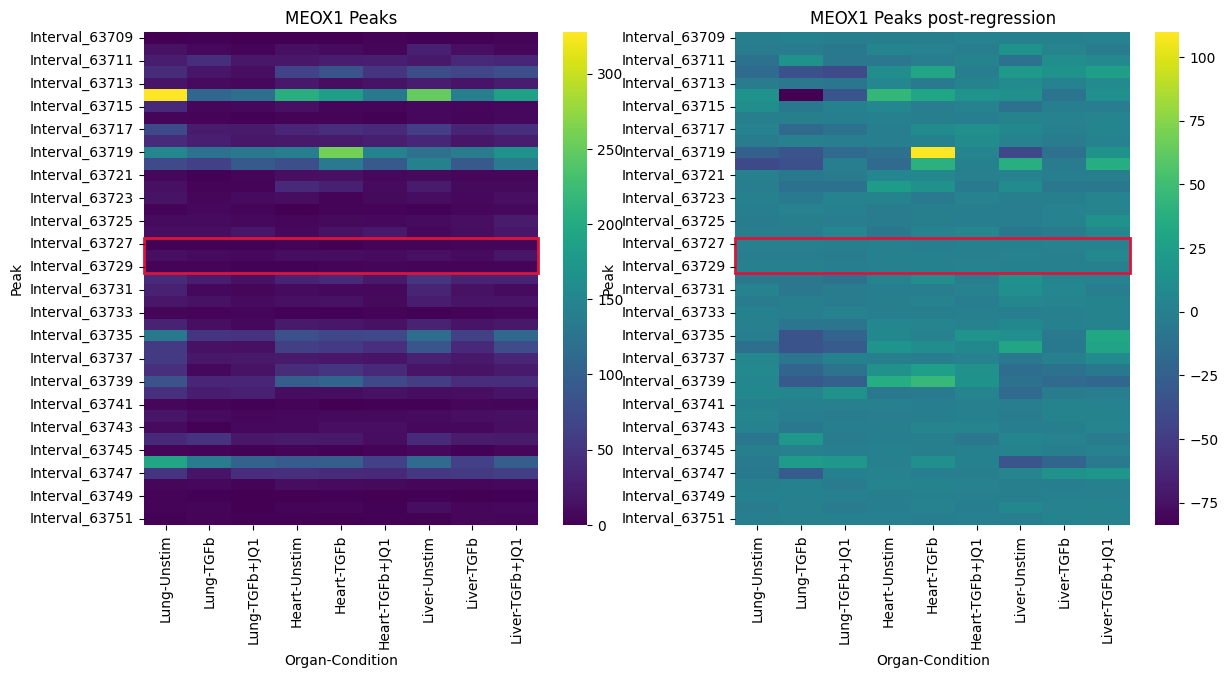

In [33]:
# MEOX1 peaks (Location according to UCSC is chr17, 43.64 - 43.66 Mb, expanding 150kb on either end)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 6.4))
plot_peak_range(atac_adata, chr=17, orf=(43.64, 43.66), ax=ax1)
ax1.set_title("MEOX1 Peaks")
plot_peak_range(atac_adata, chr=17, orf=(43.64, 43.66), ax=ax2, layer='post-regression')
ax2.set_title("MEOX1 Peaks post-regression")
plt.show()

In [44]:
# chr17:43,616,437-43,616,691 <- orthologous to mouse peak 5
# chr17:43,616,835-43,617,184 <- orthologous to mouse peak 5
# not captured in this data
atac_adata[:, ['Interval_63723', 'Interval_63724']].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63723,chr17,43614858,43615602,+,745
Interval_63724,chr17,43622133,43622721,+,589


In [36]:
# chr17:43,591,770-43,592,120 <- orthologous to mouse peak 10
# chr17:43,592,215-43,592,517 <- orthologous to mouse peak 9
# 63720 seems to bridge both of these intervals
atac_adata[:, 'Interval_63720'].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63720,chr17,43591191,43592816,+,1626


In [50]:
# chr17:43,577,707-43,577,887 <- orthologous to mouse peak 13
# chr17:43,578,079-43,578,427 <- orthologous to mouse peak 13
# chr17:43,578,441-43,578,702 <- orthologous to mouse peak 13
# regions seem to be directly flanking
atac_adata[:, ['Interval_63718', 'Interval_63719']].var

,Chr,Start,End,Strand,Length
Geneid,,,,,
Interval_63718,chr17,43576650,43577072,+,423
Interval_63719,chr17,43578751,43580003,+,1253


In [122]:
# boxplot of peak over organ/condition
def plot_peak(adata: ad.AnnData, peak: str, layer: str = None, **kwargs) -> plt.Axes:
  ax = sns.boxplot(adata.obs, x = 'organ', y = adata[:, peak].to_df(layer = layer).sum(axis = 1), order=markers.keys(), hue = 'condition', palette=palette, hue_order = palette.keys(), **kwargs)
  ax.set_ylabel(f'{peak} consensus peaks {layer if layer is not None else ""}')
  return ax

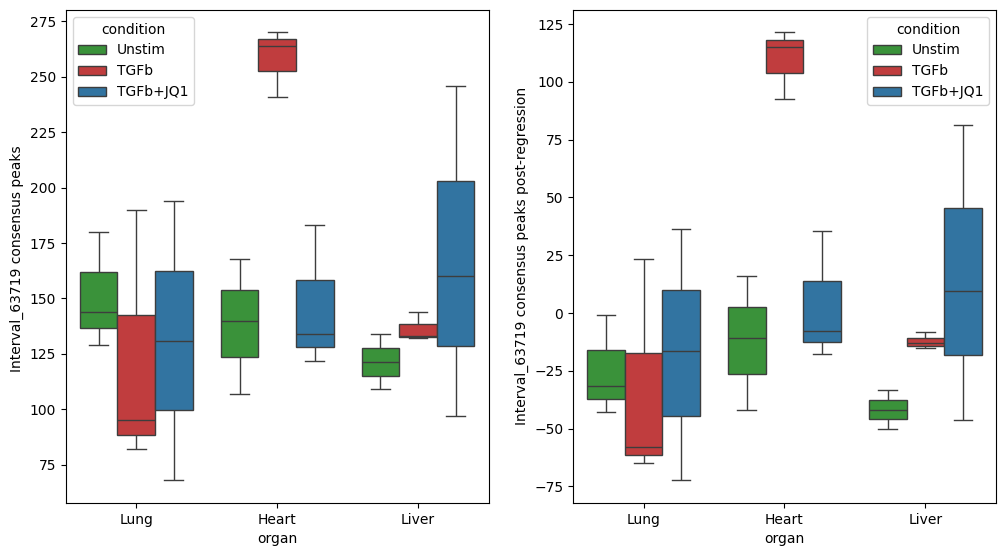

In [123]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63719', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63719', ax=ax2, layer = 'post-regression')
plt.show()

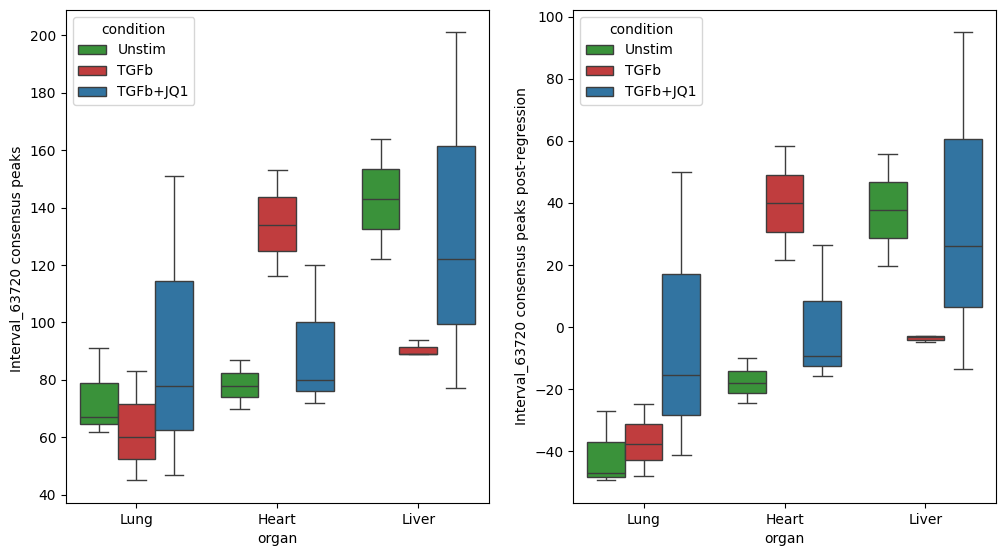

In [124]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63720', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63720', ax=ax2, layer = 'post-regression')
plt.show()

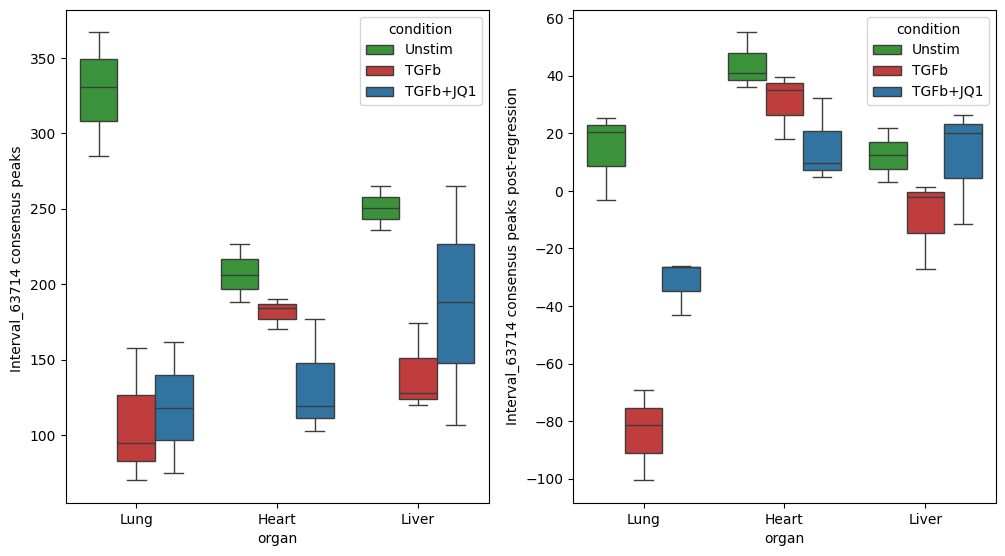

In [125]:
# Meox1 peaks
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6.4))
plot_peak(atac_adata, peak = 'Interval_63714', ax=ax1)
plot_peak(atac_adata, peak = 'Interval_63714', ax=ax2, layer = 'post-regression')
plt.show()

In [126]:
# save files
atac_adata.write('./data/atac.h5ad')
rna_adata.write('./data/rna.h5ad')

/projectnb/paxlab/dillon/OrganFibrosisConditionalGRNs/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/projectnb/paxlab/dillon/OrganFibrosisConditionalGRNs/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
